In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Dataframe preparation

In [2]:
df = pd.read_csv('flight_data_SAN.csv')

In [3]:
df.head()

,airline,flightno,origin,dest,totalseatcount,generalacft,depgate,arrgate,scheduled_departure_dttm,scheduled_arrival_dttm,actual_departure_dttm,actual_arrival_dttm,airtime,taxiout,taxiin,depvariance,arrvariance,internationalflag
0,AC,1886,SAN,YYZ,174,32S,034,F36,2018-01-01 11:40:00,2018-01-01 19:11:00,2018-01-01 13:03:00,2018-01-01 21:14:00,251.0,34.0,26.0,83.0,123.0,1
1,WN,6418,SAN,TUS,143,737,8,A3,2018-01-01 21:55:00,2018-01-02 00:10:00,2018-01-01 22:30:00,2018-01-02 00:36:00,50.0,12.0,4.0,35.0,26.0,0
2,AS,3456,SAN,STL,76,EMJ,18,C15,2018-01-01 09:40:00,2018-01-01 15:02:00,2018-01-01 09:37:00,2018-01-01 15:04:00,189.0,14.0,4.0,-3.0,2.0,0
3,WN,552,SAN,SMF,143,737,8,B15,2018-01-01 19:10:00,2018-01-01 20:45:00,2018-01-01 19:53:00,2018-01-01 21:19:00,67.0,15.0,4.0,43.0,34.0,0
4,WN,983,SAN,SMF,143,737,1A,B17,2018-01-01 15:05:00,2018-01-01 16:40:00,2018-01-01 15:15:00,2018-01-01 16:43:00,70.0,14.0,4.0,10.0,3.0,0


In [4]:
# taxiout is our target variable. Null values are detrimental so removing them
df = df[(df['taxiout'].notna()) & (df['actual_departure_dttm'].notna())]
df.isna().sum()


airline                        0
flightno                       0
origin                         0
dest                           0
totalseatcount                 0
generalacft                  162
depgate                     3279
arrgate                     5688
scheduled_departure_dttm       0
scheduled_arrival_dttm         0
actual_departure_dttm          0
actual_arrival_dttm          160
airtime                      177
taxiout                        0
taxiin                       582
depvariance                    0
arrvariance                  164
internationalflag              0
dtype: int64

In [5]:
df['actual_departure_dttm'] = pd.to_datetime(df['actual_departure_dttm'])

# Sort the data by time
df = df.sort_values('actual_departure_dttm')

# Calculate rolling window counts within a given time window
df['dep_within_5min'] = df.rolling('5T', on='actual_departure_dttm').actual_departure_dttm.count()
df['dep_within_10min'] = df.rolling('10T', on='actual_departure_dttm').actual_departure_dttm.count()
df['dep_within_15min'] = df.rolling('15T', on='actual_departure_dttm').actual_departure_dttm.count()
df['dep_within_20min'] = df.rolling('20T', on='actual_departure_dttm').actual_departure_dttm.count()
df['dep_within_25min'] = df.rolling('25T', on='actual_departure_dttm').actual_departure_dttm.count()
df['dep_within_30min'] = df.rolling('30T', on='actual_departure_dttm').actual_departure_dttm.count()
df['dep_within_60min'] = df.rolling('60T', on='actual_departure_dttm').actual_departure_dttm.count()

/var/folders/kc/klx_7jq14yz4kqywvhhh3hz40000gn/T/ipykernel_11160/1037905308.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['dep_within_5min'] = df.rolling('5T', on='actual_departure_dttm').actual_departure_dttm.count()
/var/folders/kc/klx_7jq14yz4kqywvhhh3hz40000gn/T/ipykernel_11160/1037905308.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['dep_within_10min'] = df.rolling('10T', on='actual_departure_dttm').actual_departure_dttm.count()
/var/folders/kc/klx_7jq14yz4kqywvhhh3hz40000gn/T/ipykernel_11160/1037905308.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['dep_within_15min'] = df.rolling('15T', on='actual_departure_dttm').actual_departure_dttm.count()
/var/folders/kc/klx_7jq14yz4kqywvhhh3hz40000gn/T/ipykernel_11160/1037905308.py:10: FutureWarning: 'T' is deprecated and will be removed in a future

In [6]:
# Indexing using actual departure date time as the conditions then would have the most impact on the taxi out time
df = df.set_index('actual_departure_dttm')
df.index = pd.to_datetime(df.index)
df.head()

,airline,flightno,origin,dest,totalseatcount,generalacft,depgate,arrgate,scheduled_departure_dttm,scheduled_arrival_dttm,...,depvariance,arrvariance,internationalflag,dep_within_5min,dep_within_10min,dep_within_15min,dep_within_20min,dep_within_25min,dep_within_30min,dep_within_60min
actual_departure_dttm,,,,,,,,,,,,,,,,,,,,,
2017-01-01 06:13:00,F9,552,SAN,DEN,138,32S,12,A42,2017-01-01 06:20:00,2017-01-01 09:57:00,...,-7.0,-9.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-01-01 06:14:00,AA,6022,SAN,LAX,76,EMJ,32,60C,2017-01-01 06:20:00,2017-01-01 07:25:00,...,-6.0,-20.0,0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2017-01-01 06:14:00,UA,1100,SAN,IAH,167,737,39,C30,2017-01-01 06:15:00,2017-01-01 11:28:00,...,-1.0,-5.0,0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2017-01-01 06:15:00,UA,751,SAN,EWR,152,737,41,C111,2017-01-01 06:15:00,2017-01-01 14:29:00,...,0.0,-15.0,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
2017-01-01 06:15:00,UA,400,SAN,SFO,120,32S,45,63,2017-01-01 06:15:00,2017-01-01 07:58:00,...,0.0,-7.0,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


<Axes: xlabel='internationalflag', ylabel='taxiout'>

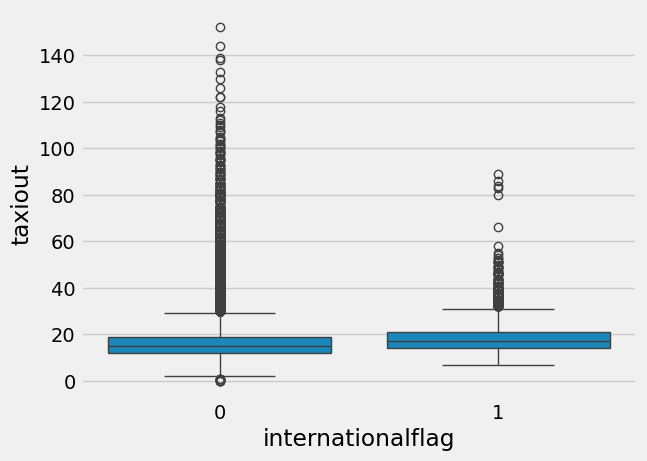

In [7]:
# Above 200 looks like outliers and makes graph hard to read
sns.boxplot(data = df[df['taxiout']<200], x = 'internationalflag', y='taxiout')

#### International seems to have impact on taxiout time, so we will do 2 different predictions - one for international and another for domestic flights

## Outlier

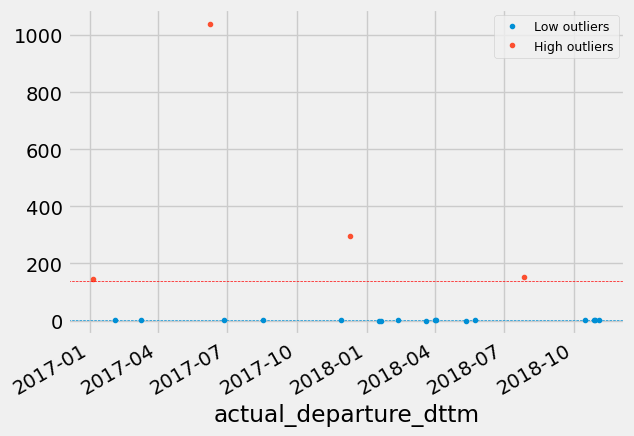

In [8]:
lower_limit = 3
upper_limit = 140
fix, ax = plt.subplots()
df[df['taxiout'] < lower_limit][['taxiout']].plot(style='.', ax = ax)
df[df['taxiout'] > upper_limit][['taxiout']].plot(style='.', ax = ax)

ax.axhline(lower_limit, ls='--', linewidth = 0.5)
ax.axhline(upper_limit, color='red', ls='--', linewidth = 0.5)
ax.legend(['Low outliers', 'High outliers'], prop={'size':'9'})
plt.show()

In [9]:
df = df[(df['taxiout'] >= lower_limit) & (df['taxiout'] <= upper_limit)]

In [10]:
df = df[['taxiout', 
             'dep_within_5min', 
             'dep_within_10min', 
             'dep_within_15min',
             'dep_within_20min',
             'dep_within_25min',
             'dep_within_30min']].sort_index().resample('1h').agg(['mean', 'count'])
df.columns = ['_'.join(col).strip() for col in df.columns]
df = df[['taxiout_mean', 
        'taxiout_count', 
        'dep_within_5min_mean', 
        'dep_within_10min_mean', 
        'dep_within_15min_mean',
        'dep_within_20min_mean',
        'dep_within_25min_mean',
        'dep_within_30min_mean']]
df.columns = ['taxiout', 
        'count', 
        'dep_within_5min', 
        'dep_within_10min', 
        'dep_within_15min',
        'dep_within_20min',
        'dep_within_25min',
        'dep_within_30min']
df = df[(df['taxiout'].notna())].sort_index()
df

,taxiout,count,dep_within_5min,dep_within_10min,dep_within_15min,dep_within_20min,dep_within_25min,dep_within_30min
actual_departure_dttm,,,,,,,,
2017-01-01 06:00:00,17.428571,21,2.619048,3.857143,5.666667,6.857143,7.904762,8.761905
2017-01-01 07:00:00,14.812500,16,2.187500,3.250000,4.625000,5.625000,7.062500,9.000000
2017-01-01 08:00:00,13.846154,13,2.000000,2.538462,3.538462,4.384615,5.230769,6.846154
2017-01-01 09:00:00,14.142857,14,2.000000,3.214286,4.500000,5.142857,6.000000,6.714286
2017-01-01 10:00:00,16.214286,14,2.000000,3.428571,4.428571,5.000000,6.071429,7.000000
...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00,16.454545,11,1.727273,2.727273,3.727273,4.636364,5.454545,6.090909
2018-12-31 19:00:00,20.166667,12,2.083333,2.750000,3.583333,4.083333,4.750000,5.083333
2018-12-31 20:00:00,14.000000,6,1.666667,2.333333,2.500000,2.833333,3.333333,4.166667


In [11]:
def create_features(df):
    date_range=[
        # New year/Christmas
        (pd.Timestamp('2016-12-15'), pd.Timestamp('2017-01-15')),
        (pd.Timestamp('2017-12-15'), pd.Timestamp('2018-01-15')),
        (pd.Timestamp('2018-12-15'), pd.Timestamp('2019-01-15')),
        (pd.Timestamp('2019-12-15'), pd.Timestamp('2020-01-15')),
        # Independence day
        (pd.Timestamp('2017-07-01'), pd.Timestamp('2017-07-07')),
        (pd.Timestamp('2018-07-01'), pd.Timestamp('2018-07-07')),
        (pd.Timestamp('2019-07-01'), pd.Timestamp('2019-07-07')),
        # Labor day
        (pd.Timestamp('2017-09-01'), pd.Timestamp('2017-09-07')),
        (pd.Timestamp('2018-08-31'), pd.Timestamp('2018-09-06')),
        (pd.Timestamp('2019-08-30'), pd.Timestamp('2019-09-05')),
        # Memorial day
        (pd.Timestamp('2017-05-26'), pd.Timestamp('2017-06-01')),
        (pd.Timestamp('2018-05-25'), pd.Timestamp('2018-05-31')),
        (pd.Timestamp('2019-05-24'), pd.Timestamp('2019-05-30')),
        # Thanksgiving day
        (pd.Timestamp('2017-11-20'), pd.Timestamp('2017-11-26')),
        (pd.Timestamp('2018-11-19'), pd.Timestamp('2018-11-25')),
        (pd.Timestamp('2019-11-25'), pd.Timestamp('2019-12-01')),
        # Comic con dates
        (pd.Timestamp('2017-07-17'), pd.Timestamp('2017-07-26')),
        (pd.Timestamp('2018-07-16'), pd.Timestamp('2018-07-25')),
        (pd.Timestamp('2019-07-15'), pd.Timestamp('2019-07-24'))
    ]
    def get_holiday_flag(date):
        if any(start <= date <= end for start, end in date_range):
            return 1
        return 0
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    df['event_period'] = df.index.to_series().apply(lambda x: get_holiday_flag(x))
    target_map_taxiout_avg = df['taxiout'].to_dict()
    target_map_count = df['count'].to_dict()
    df['lag_1yr_taxiout'] = (df.index - pd.Timedelta('364 days')).map(target_map_taxiout_avg)
    df['lag_1yr_fuzzy_taxiout'] = (((df.index - pd.Timedelta('358 days')).map(target_map_taxiout_avg) * (df.index - pd.Timedelta('358 days')).map(target_map_count)) + 
                           ((df.index - pd.Timedelta('359 days')).map(target_map_taxiout_avg) * (df.index - pd.Timedelta('359 days')).map(target_map_count)) + 
                           ((df.index - pd.Timedelta('360 days')).map(target_map_taxiout_avg) * (df.index - pd.Timedelta('360 days')).map(target_map_count)) + 
                           ((df.index - pd.Timedelta('361 days')).map(target_map_taxiout_avg) * (df.index - pd.Timedelta('361 days')).map(target_map_count)) + 
                           ((df.index - pd.Timedelta('362 days')).map(target_map_taxiout_avg) * (df.index - pd.Timedelta('362 days')).map(target_map_count)) + 
                           ((df.index - pd.Timedelta('363 days')).map(target_map_taxiout_avg) * (df.index - pd.Timedelta('363 days')).map(target_map_count)) + 
                           ((df.index - pd.Timedelta('364 days')).map(target_map_taxiout_avg) * (df.index - pd.Timedelta('364 days')).map(target_map_count)) + 
                           ((df.index - pd.Timedelta('365 days')).map(target_map_taxiout_avg) * (df.index - pd.Timedelta('365 days')).map(target_map_count)) + 
                           ((df.index - pd.Timedelta('366 days')).map(target_map_taxiout_avg) * (df.index - pd.Timedelta('366 days')).map(target_map_count)) + 
                           ((df.index - pd.Timedelta('367 days')).map(target_map_taxiout_avg) * (df.index - pd.Timedelta('367 days')).map(target_map_count)) + 
                           ((df.index - pd.Timedelta('368 days')).map(target_map_taxiout_avg) * (df.index - pd.Timedelta('368 days')).map(target_map_count)) + 
                           ((df.index - pd.Timedelta('369 days')).map(target_map_taxiout_avg) * (df.index - pd.Timedelta('369 days')).map(target_map_count)) + 
                           ((df.index - pd.Timedelta('370 days')).map(target_map_taxiout_avg) * (df.index - pd.Timedelta('370 days')).map(target_map_count)) + 
                           ((df.index - pd.Timedelta('371 days')).map(target_map_taxiout_avg) * (df.index - pd.Timedelta('371 days')).map(target_map_count)) + 
                           ((df.index - pd.Timedelta('372 days')).map(target_map_taxiout_avg) * (df.index - pd.Timedelta('372 days')).map(target_map_count))
                          )/((df.index - pd.Timedelta('358 days')).map(target_map_count) + 
                              (df.index - pd.Timedelta('359 days')).map(target_map_count) +
                              (df.index - pd.Timedelta('360 days')).map(target_map_count) +
                              (df.index - pd.Timedelta('361 days')).map(target_map_count) +
                              (df.index - pd.Timedelta('362 days')).map(target_map_count) +
                              (df.index - pd.Timedelta('363 days')).map(target_map_count) +
                              (df.index - pd.Timedelta('364 days')).map(target_map_count) +
                              (df.index - pd.Timedelta('365 days')).map(target_map_count) +
                              (df.index - pd.Timedelta('366 days')).map(target_map_count) +
                              (df.index - pd.Timedelta('367 days')).map(target_map_count) +
                              (df.index - pd.Timedelta('368 days')).map(target_map_count) +
                              (df.index - pd.Timedelta('369 days')).map(target_map_count) +
                              (df.index - pd.Timedelta('370 days')).map(target_map_count) +
                              (df.index - pd.Timedelta('371 days')).map(target_map_count) +
                              (df.index - pd.Timedelta('372 days')).map(target_map_count))
    df['lag_1yr_fuzzy_taxiout_max'] = np.maximum.reduce([(df.index - pd.Timedelta('358 days')).map(target_map_taxiout_avg),  
                           (df.index - pd.Timedelta('359 days')).map(target_map_taxiout_avg),  
                           (df.index - pd.Timedelta('360 days')).map(target_map_taxiout_avg),  
                           (df.index - pd.Timedelta('361 days')).map(target_map_taxiout_avg),  
                           (df.index - pd.Timedelta('362 days')).map(target_map_taxiout_avg),  
                           (df.index - pd.Timedelta('363 days')).map(target_map_taxiout_avg),  
                           (df.index - pd.Timedelta('364 days')).map(target_map_taxiout_avg),  
                           (df.index - pd.Timedelta('365 days')).map(target_map_taxiout_avg),  
                           (df.index - pd.Timedelta('366 days')).map(target_map_taxiout_avg),  
                           (df.index - pd.Timedelta('367 days')).map(target_map_taxiout_avg),  
                           (df.index - pd.Timedelta('368 days')).map(target_map_taxiout_avg),  
                           (df.index - pd.Timedelta('369 days')).map(target_map_taxiout_avg),  
                           (df.index - pd.Timedelta('370 days')).map(target_map_taxiout_avg),  
                           (df.index - pd.Timedelta('371 days')).map(target_map_taxiout_avg),  
                           (df.index - pd.Timedelta('372 days')).map(target_map_taxiout_avg)])
    return df

In [12]:
df = create_features(df)

## Time series cross validation

In [13]:
## Traditional train test split

# train = df.loc[df.index < '2018-10-01']
# test = df.loc[df.index >= '2018-10-01']

# fix, ax = plt.subplots(figsize=(30, 15))
# train.plot(ax=ax, label='Training set', title='Train/test split')
# test.plot(ax=ax, label='Test set')
# ax.axvline('2018-10-01', color='black', ls='--')
# ax.legend(['Training set', 'Test set'])
# plt.show()


In [14]:
from sklearn.model_selection import TimeSeriesSplit

In [15]:
tss = TimeSeriesSplit(n_splits=3, test_size=24*30*2, gap=0)
df = df.sort_index()

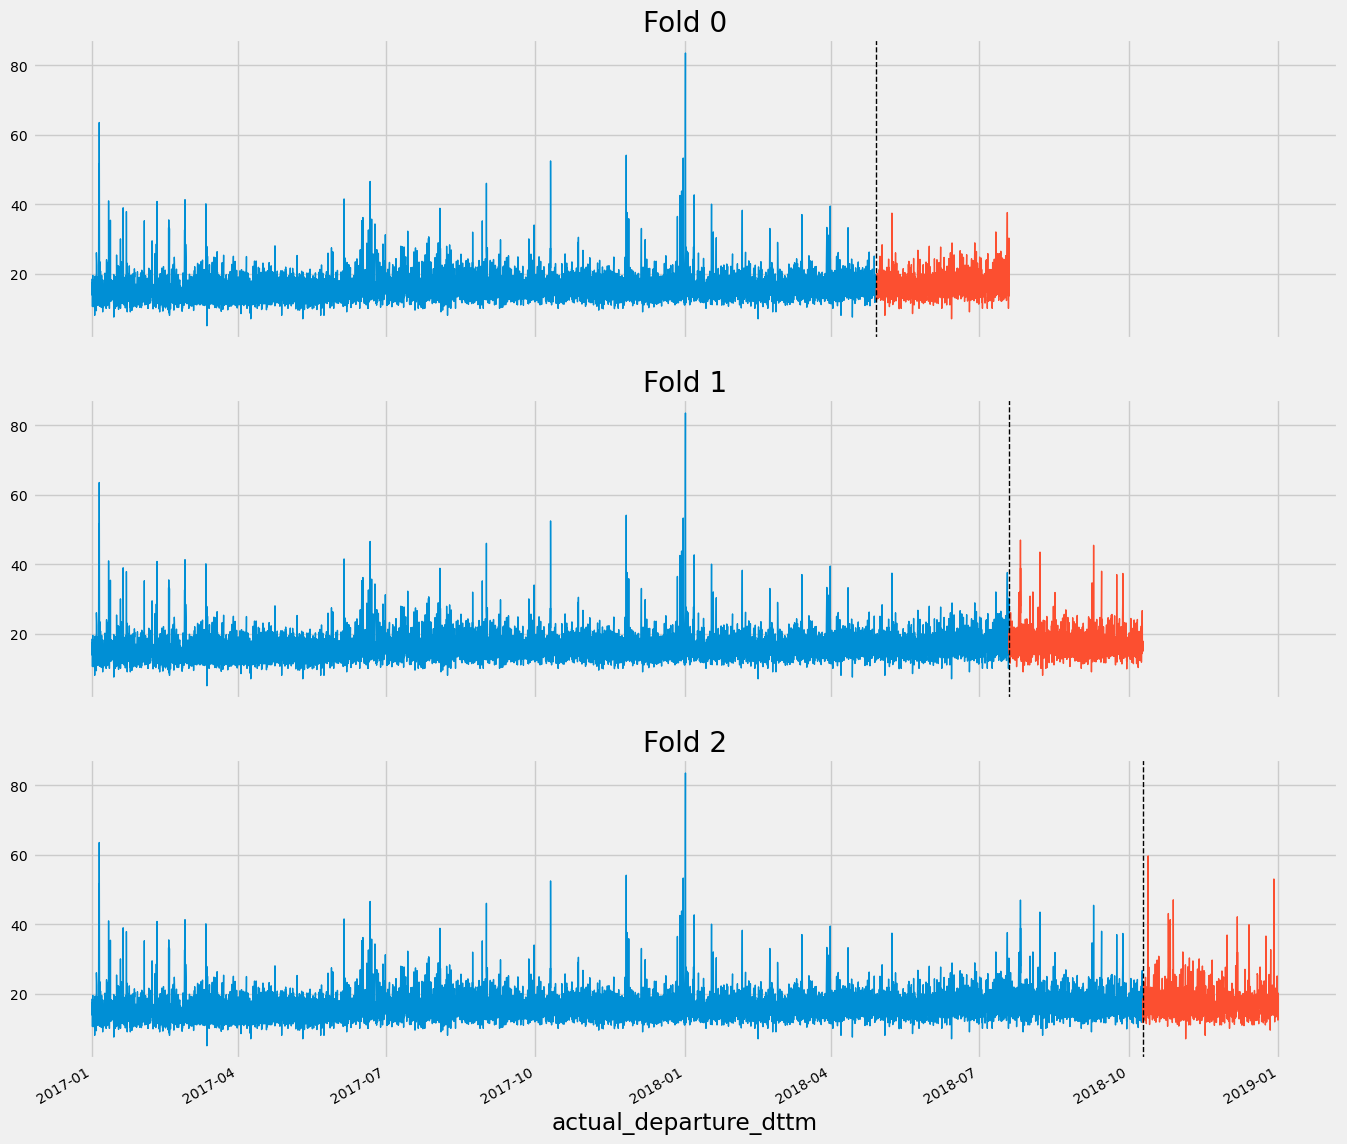

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['taxiout'].plot(ax=axs[fold], label='Training Set', title=f'Fold {fold}', linewidth=1, fontsize=10)
    test['taxiout'].plot(ax=axs[fold], label='Test Set', linewidth=1)
    axs[fold].axvline(test.index.min(), color='black', linewidth=1, ls='--')
    fold+=1

plt.show()


In [17]:
from sklearn.metrics import mean_squared_error
FEATURES = df.columns.tolist()
FEATURES.remove('taxiout')

TARGET = 'taxiout'

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    print('FOLD: ' + str(fold))
    print(train_idx, val_idx)
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]

    print(X_train.tail())
    
    reg = xgb.XGBRegressor(base_score = 0.5,
                           booster='gbtree',
                           n_estimators=5000,
                           early_stopping_rounds = 50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)], verbose=25)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    fold += 1
    break

FOLD: 0
[   0    1    2 ... 8422 8423 8424] [8425 8426 8427 ... 9862 9863 9864]
                       count  dep_within_5min  dep_within_10min  \
actual_departure_dttm                                             
2018-04-28 11:00:00       19         2.368421          3.736842   
2018-04-28 12:00:00       15         1.933333          3.466667   
2018-04-28 13:00:00       17         2.000000          3.117647   
2018-04-28 14:00:00       12         1.666667          2.666667   
2018-04-28 15:00:00       18         2.222222          3.333333   

                       dep_within_15min  dep_within_20min  dep_within_25min  \
actual_departure_dttm                                                         
2018-04-28 11:00:00            4.842105          6.421053          7.526316   
2018-04-28 12:00:00            4.533333          5.933333          7.533333   
2018-04-28 13:00:00            4.470588          6.117647          7.117647   
2018-04-28 14:00:00            4.083333          4.9166

In [18]:
print(f'Scores across folds: {np.mean(scores):0.4f}')
print(f'Fold scores: {scores}')

Scores across folds: 2.4277
Fold scores: [2.4277315092819154]


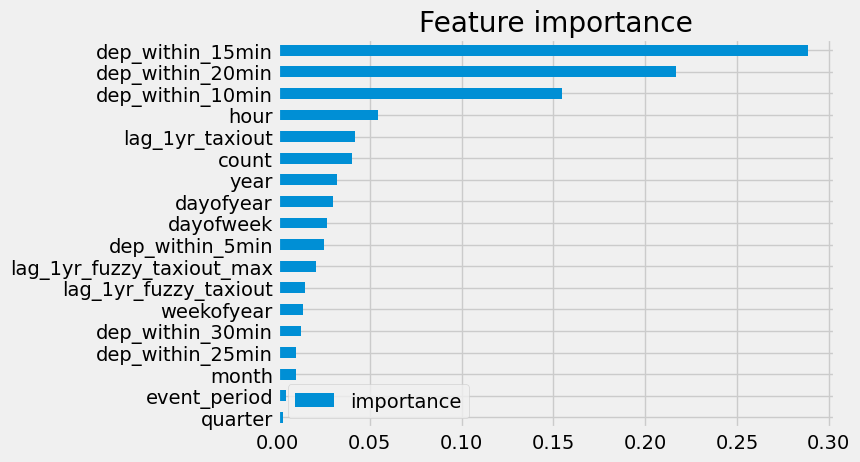

In [19]:
fi = pd.DataFrame(data = reg.feature_importances_, index = reg.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature importance')
plt.show()

In [20]:
def boxplotall(df):
    sns.boxplot(data = df, x='event_period', y='taxiout')
    plt.show()
    sns.boxplot(data = df, x='hour', y='taxiout', palette='Blues', hue='hour', legend=False)
    plt.show()
    sns.boxplot(data = df, x='dayofweek', y='taxiout')
    plt.show()
    sns.boxplot(data = df, x='quarter', y='taxiout')
    plt.show()
    sns.boxplot(data = df, x='month', y='taxiout')
    plt.show()
    fix, ax = plt.subplots(figsize=(30, 10))
    sns.boxplot(data = df, x='weekofyear', y='taxiout', ax=ax)
    plt.show()
    sns.boxplot(data = df, x='year', y='taxiout')
    plt.show()
    fix, ax = plt.subplots(figsize=(30, 10))
    sns.boxplot(data = df, x='dayofyear', y='taxiout', ax = ax)
    plt.show()

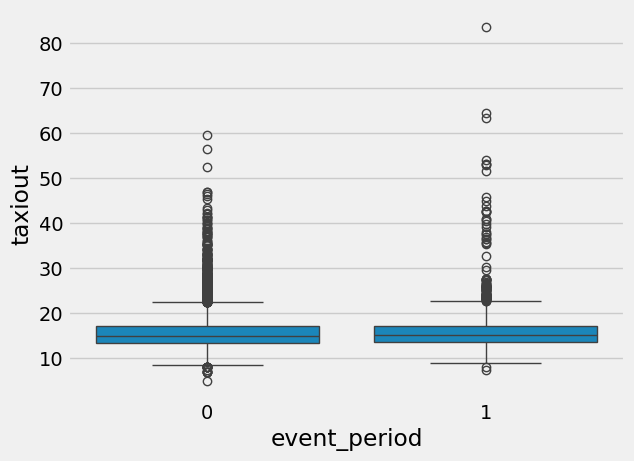

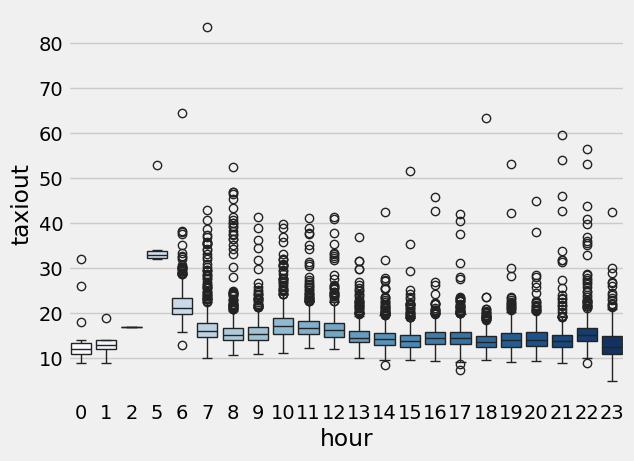

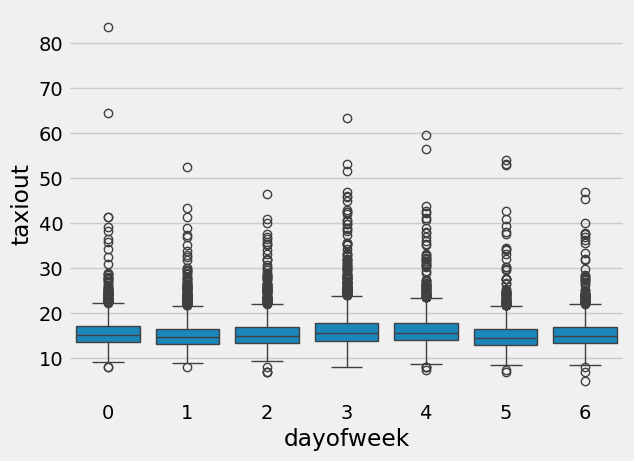

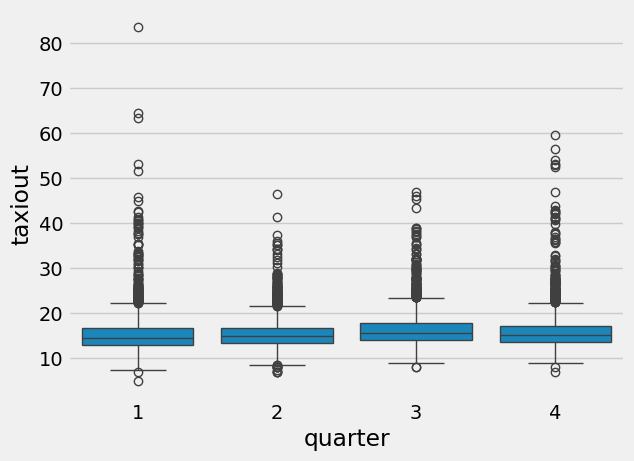

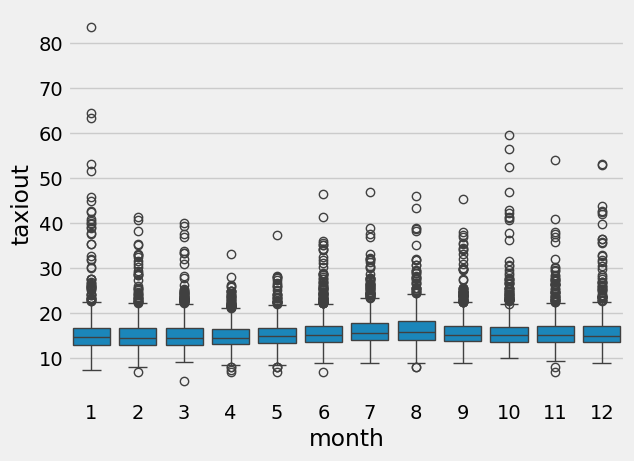

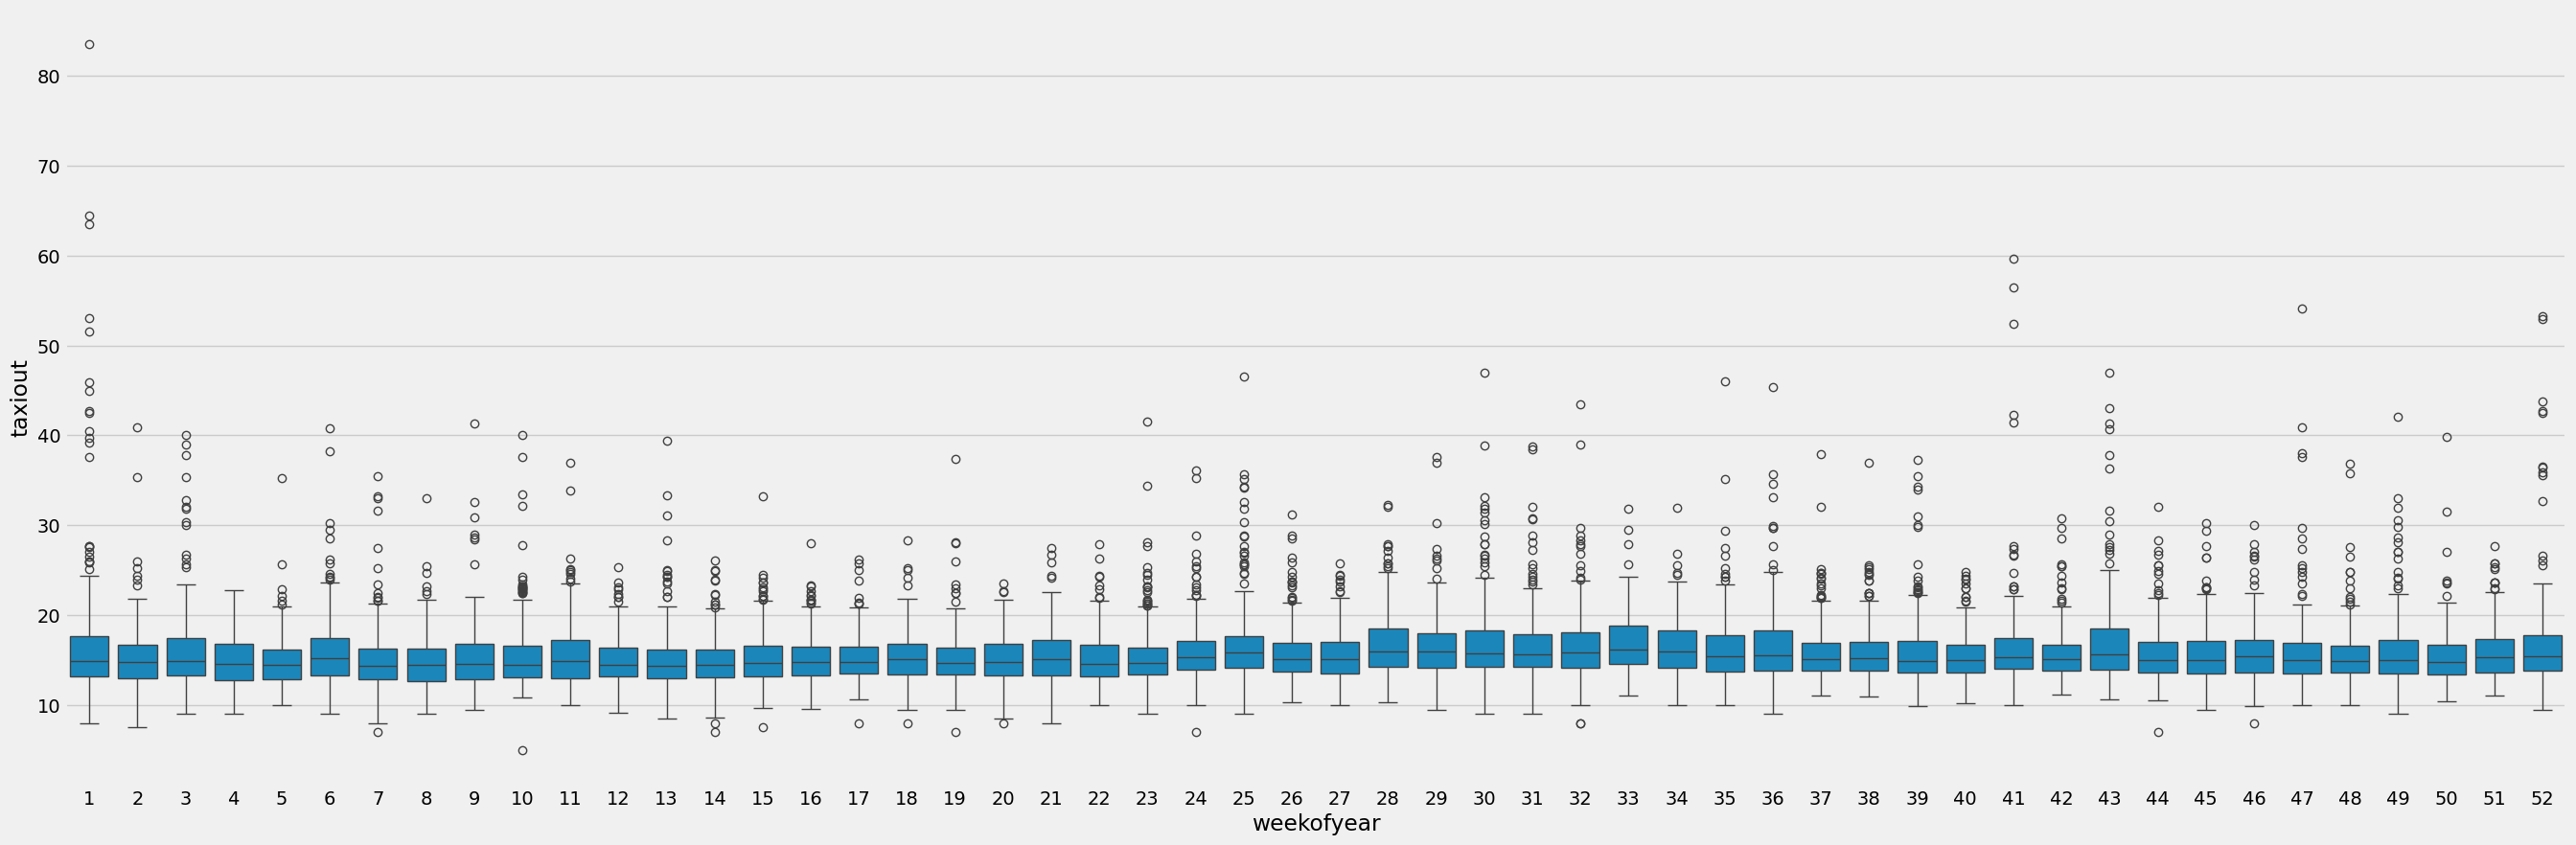

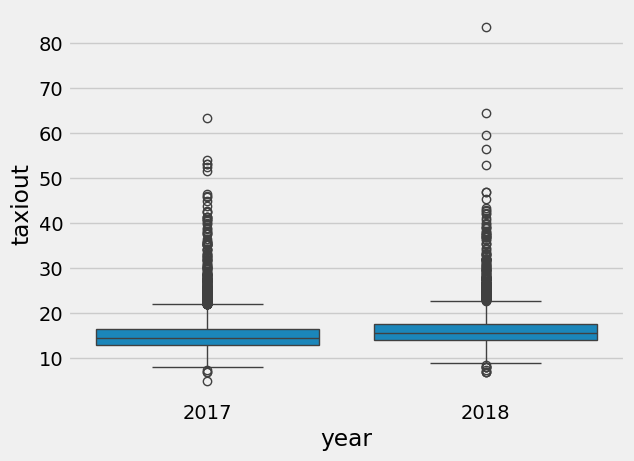

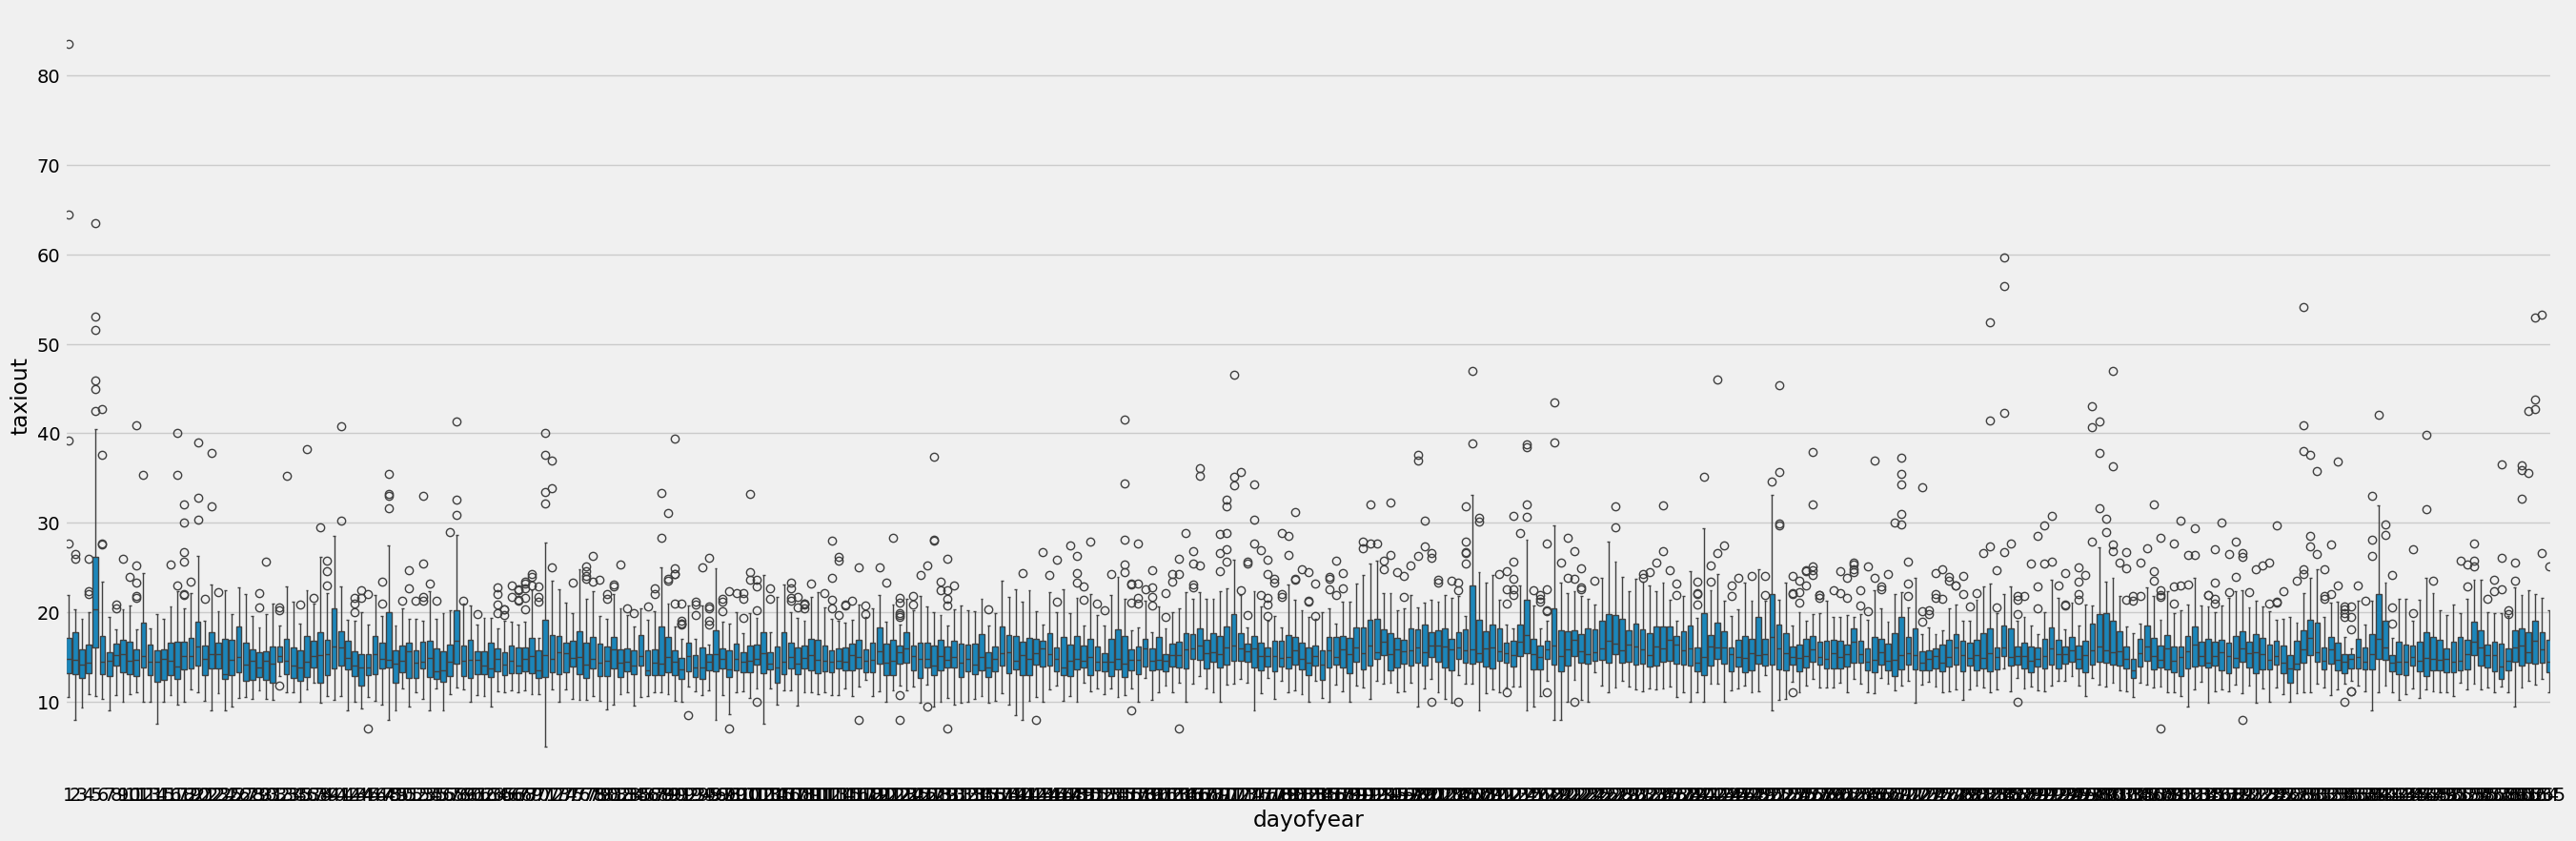

In [21]:
boxplotall(df)

In [22]:
from sklearn.metrics import mean_squared_error

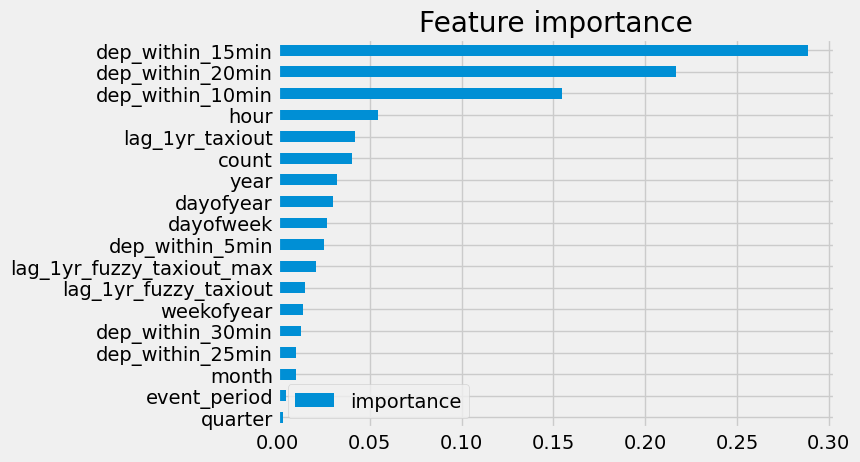

In [23]:
fi = pd.DataFrame(data = reg.feature_importances_, index = reg.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature importance')
plt.show()

# Forecast

In [24]:
df.tail()

,taxiout,count,dep_within_5min,dep_within_10min,dep_within_15min,dep_within_20min,dep_within_25min,dep_within_30min,hour,dayofweek,quarter,month,year,dayofyear,weekofyear,event_period,lag_1yr_taxiout,lag_1yr_fuzzy_taxiout,lag_1yr_fuzzy_taxiout_max
actual_departure_dttm,,,,,,,,,,,,,,,,,,,
2018-12-31 18:00:00,16.454545,11,1.727273,2.727273,3.727273,4.636364,5.454545,6.090909,18,0,4,12,2018,365,1,1,13.166667,15.125749,21.000000
2018-12-31 19:00:00,20.166667,12,2.083333,2.750000,3.583333,4.083333,4.750000,5.083333,19,0,4,12,2018,365,1,1,13.333333,14.209302,18.181818
2018-12-31 20:00:00,14.000000,6,1.666667,2.333333,2.500000,2.833333,3.333333,4.166667,20,0,4,12,2018,365,1,1,15.818182,14.133333,17.000000
2018-12-31 21:00:00,13.428571,7,1.285714,1.428571,2.285714,2.714286,4.000000,4.428571,21,0,4,12,2018,365,1,1,13.000000,16.342466,42.700000
2018-12-31 22:00:00,14.000000,5,1.200000,2.000000,2.200000,2.400000,2.800000,3.000000,22,0,4,12,2018,365,1,1,14.444444,22.966667,53.272727


In [25]:
train = df.iloc[df.index < '2018-10-01'].copy()
test = df.iloc[df.index >= '2018-10-01'].copy()

X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]


In [26]:
reg = xgb.XGBRegressor(base_score = 0.5,
                       booster='gbtree',
                       n_estimators=5000,
                       early_stopping_rounds = 50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)], verbose=25)

[0]	validation_0-rmse:15.57407	validation_1-rmse:16.39617
[25]	validation_0-rmse:12.29688	validation_1-rmse:13.08575
[50]	validation_0-rmse:9.79292	validation_1-rmse:10.53024
[75]	validation_0-rmse:7.89850	validation_1-rmse:8.58292
[100]	validation_0-rmse:6.48455	validation_1-rmse:7.13236
[125]	validation_0-rmse:5.44697	validation_1-rmse:6.06555
[150]	validation_0-rmse:4.70505	validation_1-rmse:5.30556
[175]	validation_0-rmse:4.18691	validation_1-rmse:4.77738
[200]	validation_0-rmse:3.83264	validation_1-rmse:4.41381
[225]	validation_0-rmse:3.59557	validation_1-rmse:4.17088
[250]	validation_0-rmse:3.44025	validation_1-rmse:4.01777
[275]	validation_0-rmse:3.33646	validation_1-rmse:3.92246
[300]	validation_0-rmse:3.26667	validation_1-rmse:3.85540
[325]	validation_0-rmse:3.21938	validation_1-rmse:3.81117
[350]	validation_0-rmse:3.18678	validation_1-rmse:3.78619
[375]	validation_0-rmse:3.16404	validation_1-rmse:3.77110
[400]	validation_0-rmse:3.14701	validation_1-rmse:3.76196
[425]	validati

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

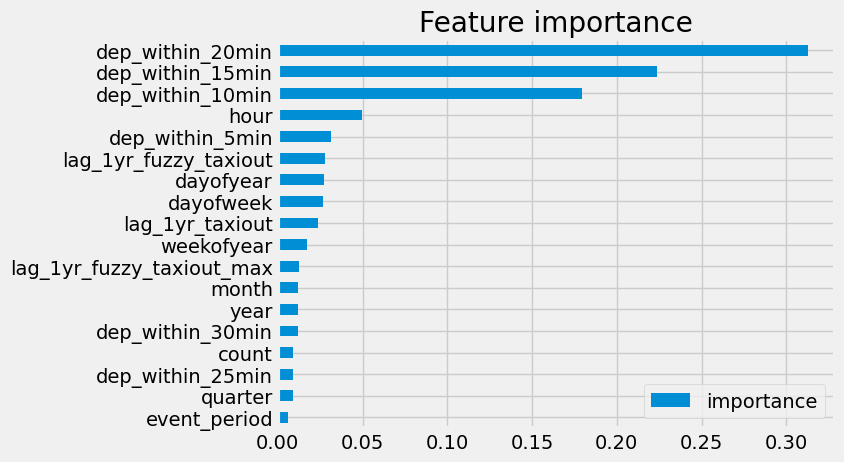

In [27]:
fi = pd.DataFrame(data = reg.feature_importances_, index = reg.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature importance')
plt.show()

In [28]:
test['prediction'] = reg.predict(X_test)

In [29]:
testdf = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

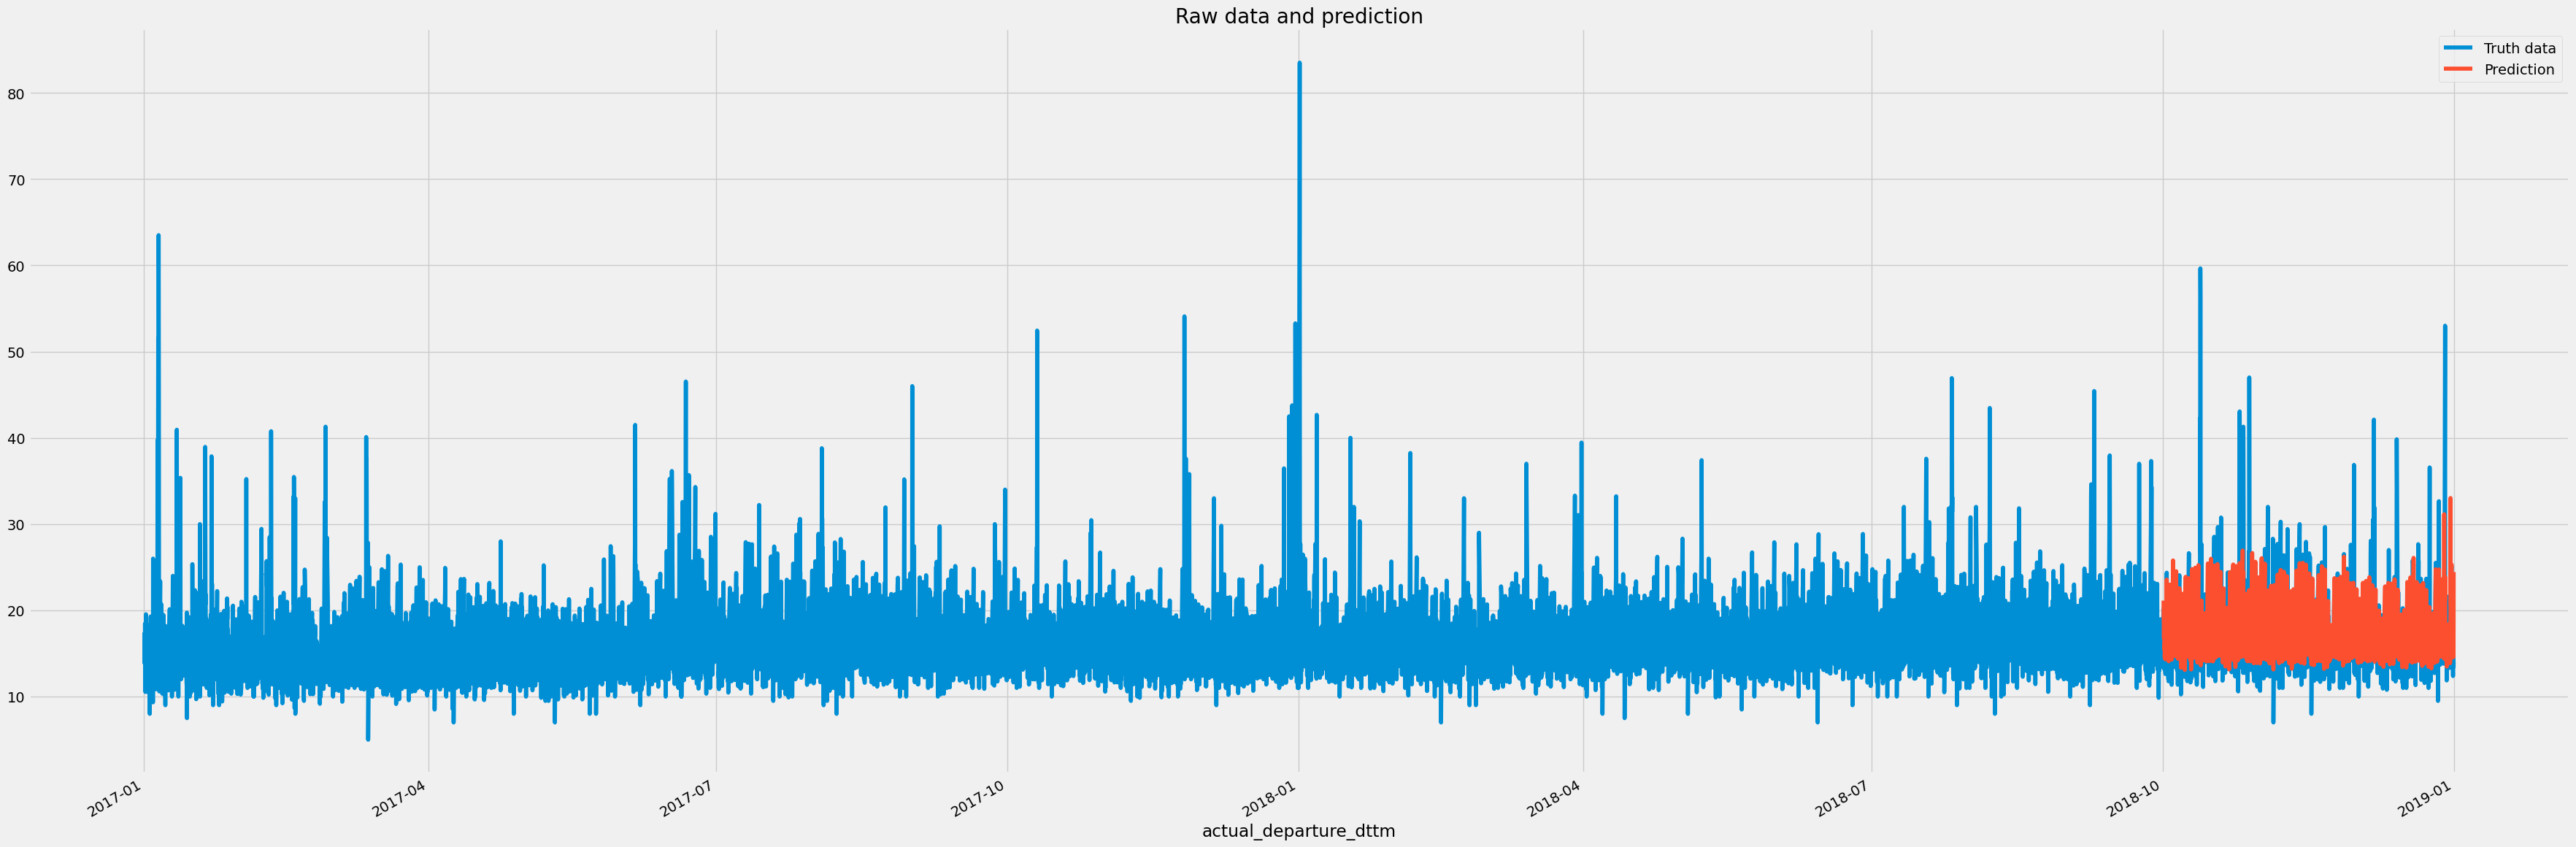

In [30]:
ax = testdf[['taxiout']].plot(figsize=(40,15))
testdf['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth data', 'Prediction'])
ax.set_title('Raw data and prediction')
plt.show()

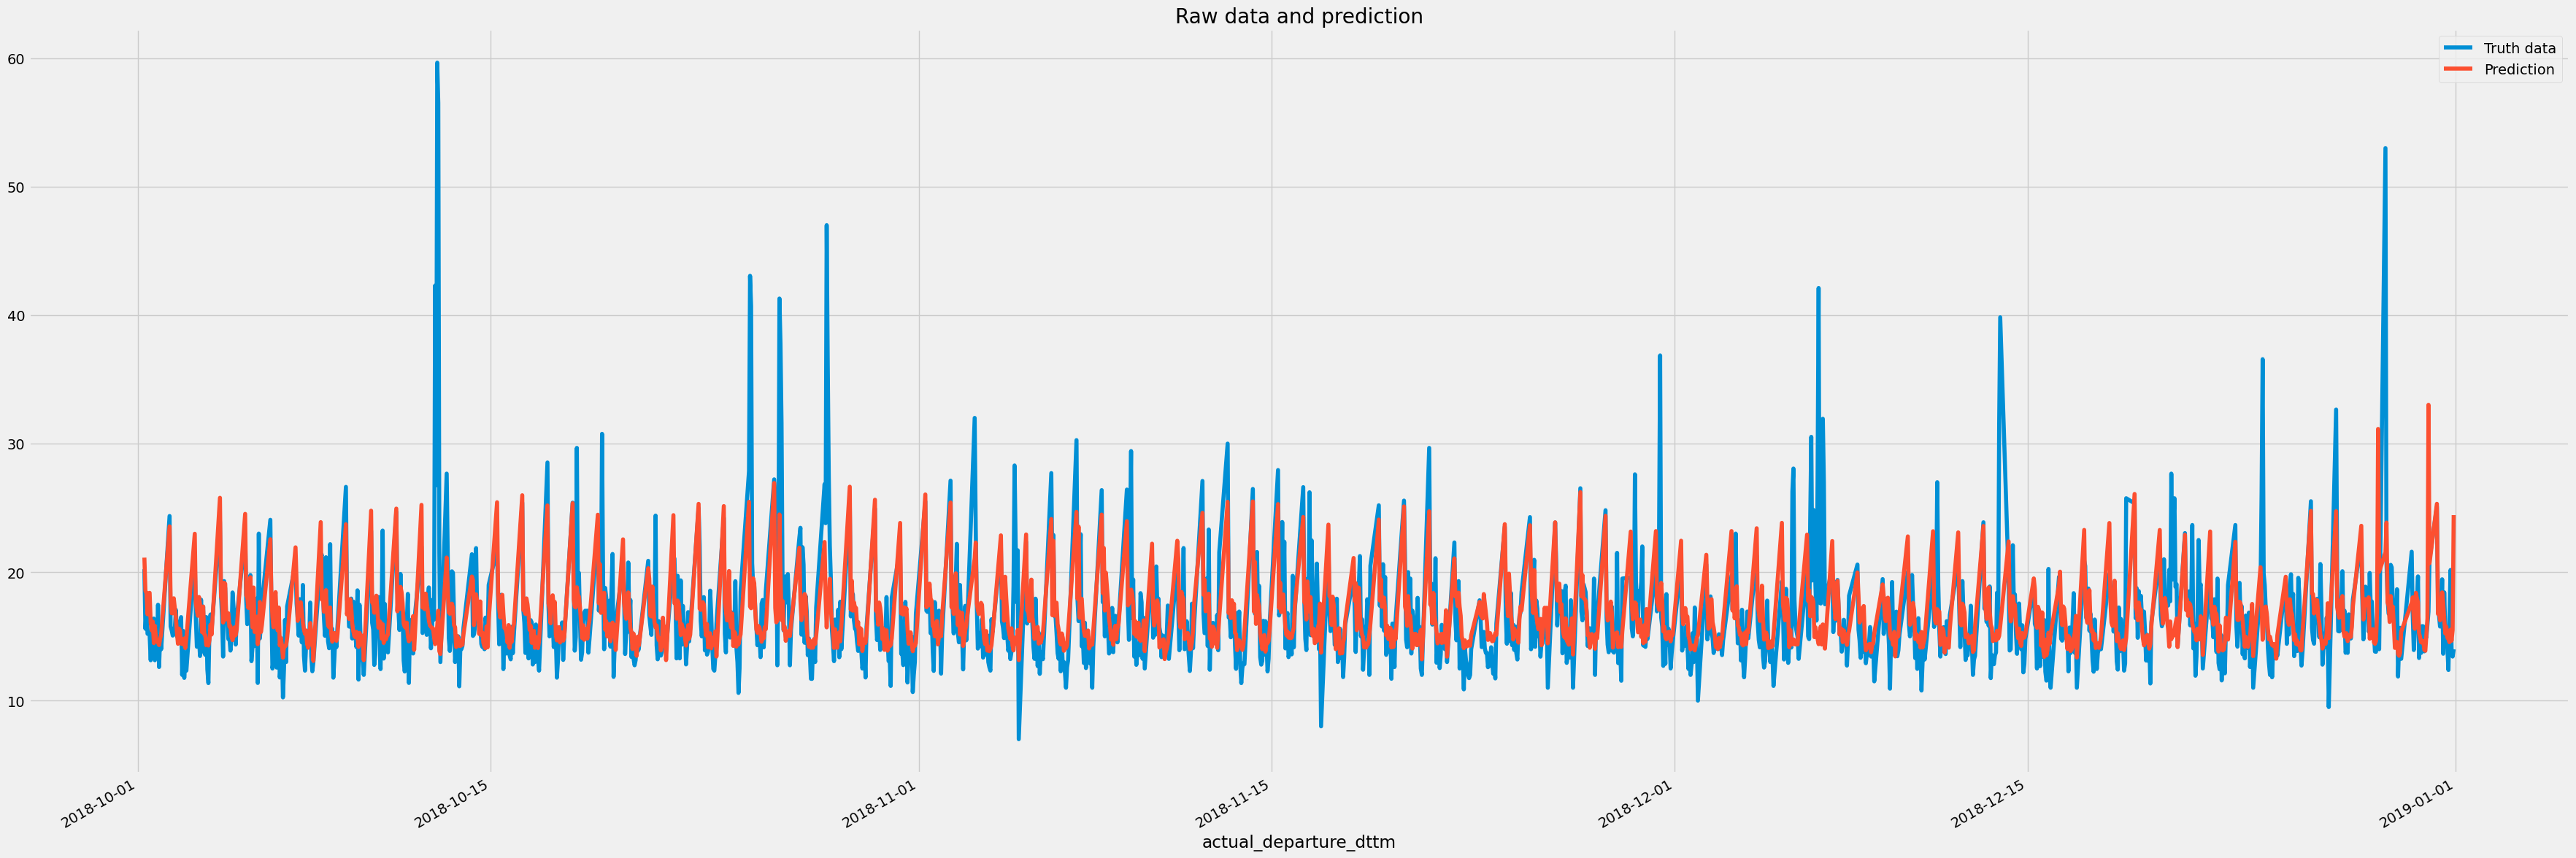

In [31]:
ax = testdf[testdf.index>='2018-10-01'][['taxiout']].plot(figsize=(40,15))
testdf['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth data', 'Prediction'])
ax.set_title('Raw data and prediction')
plt.show()

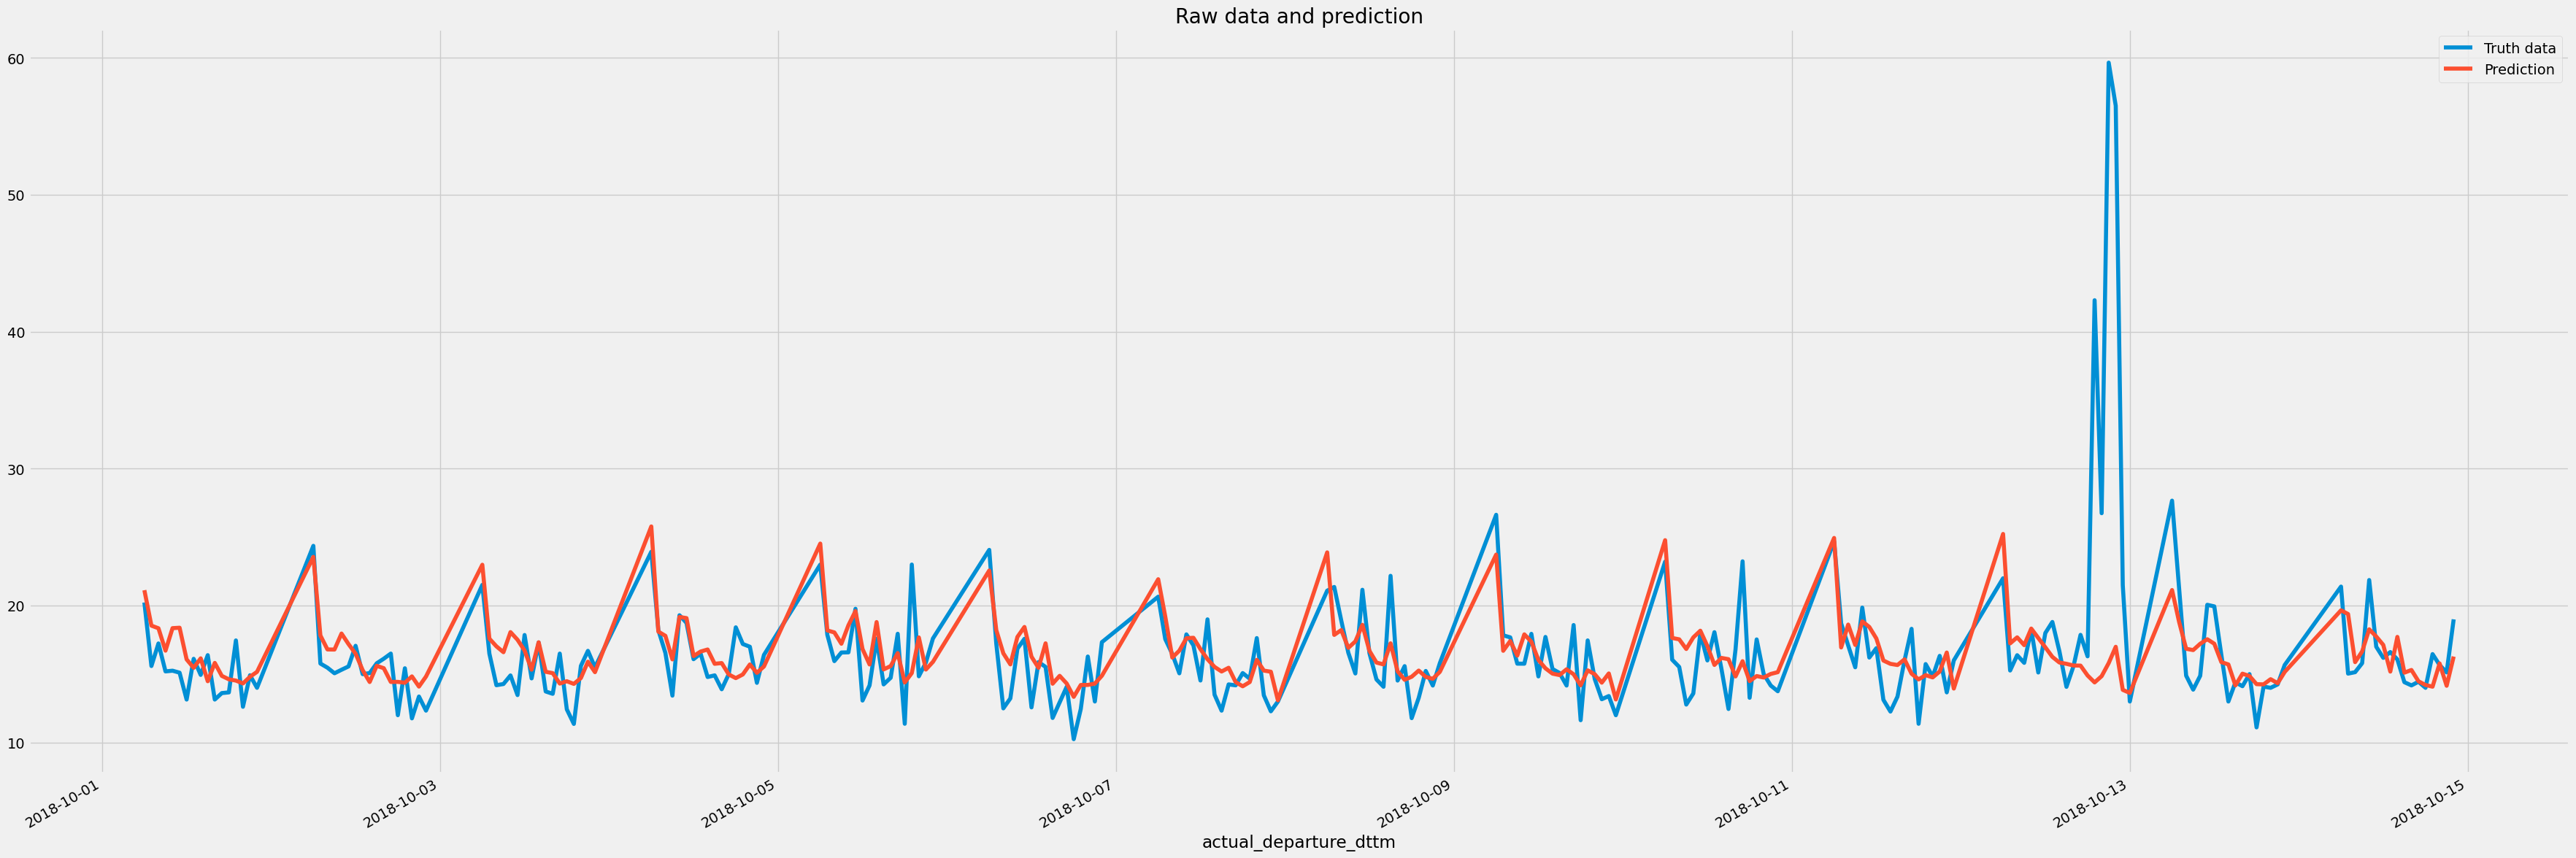

In [32]:
ax = testdf[(testdf.index>='2018-10-01') & (testdf.index<='2018-10-15')][['taxiout']].plot(figsize=(40,15))
testdf[(testdf.index>='2018-10-01') & (testdf.index<='2018-10-15')]['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth data', 'Prediction'])
ax.set_title('Raw data and prediction')
plt.show()

In [37]:
np.sqrt(mean_squared_error(testdf.iloc[df.index >= '2018-10-01']['taxiout'],
                           testdf.iloc[df.index >= '2018-10-01']['prediction']))

3.7040807284076576